In [1]:
from siameseimage.siameseimage import *

In [3]:
base_path = Path('src')

img_train = base_path / 'train_images'

df = pd.read_csv(base_path / 'train.csv')

## Prepare Data ##
## Remove duplicates
df.drop_duplicates(['image_phash'], inplace = True)

## Make shure that for each label, there are at least 2 unique images.
df_groupby_label = df.groupby(['label_group'])['image_phash'].nunique().to_frame()
keep_labels = df_groupby_label[df_groupby_label.image_phash >= 2].index.tolist()
df = df[df['label_group'].isin(keep_labels)].reset_index(drop = True)
df.drop(['title'], axis = 1, inplace = True)

if True:
    ## Decrease size of dataframe for testing purposes.
    pct = 0.1

    labels = df['label_group'].unique()
    ## Sample given percentage from the labels
    keep_labels = np.random.choice(labels, size = int(len(labels)*pct), replace = False)
    ## Restrict dataframe to instances that are in chosen labels
    df = df[df['label_group'].isin(keep_labels)]
    df = df.reset_index(drop = True)

## Randomly split labels in test/val and add column to dataframe which marks instances as test/vas
df = split_df(df, label_col = 'label_group', verbose = True)

tfm = SiameseTransform(df, path = img_train, f_col = 'image', label_col = 'label_group', val_col = 'is_valid')

tls = TfmdLists(range(df.shape[0]), tfm, splits = tfm.splits)

size = 224
bs = 32
dls = tls.dataloaders(after_item=[Resize(size), ToTensor], 
                      after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)],
                      bs = bs
                     )

arc = resnet34
cut = model_meta[arc]['cut']
encoder = create_body(arc, cut = cut)
head = create_head(512 * 2, 2, ps=0.3)
model = SiameseModel(encoder, head)

learn = Learner(dls, model, loss_func = CrossEntropyLossFlat(), splitter = siamese_splitter, metrics = accuracy).to_fp16()
learn.freeze()
learn.fine_tune(3)


Total number of labels: 996; number of train/validation labels: 797/199; relative size of validation set by labels: 19.979919678714857%.
Total number of instances: 2762, number of train/validation instances: 2199/563; relative size of validation set by instances: 20.383779869659666%.


epoch,train_loss,valid_loss,accuracy,time
0,0.765622,0.617887,0.663650,00:21


epoch,train_loss,valid_loss,accuracy,time
0,0.548149,0.467623,0.767198,00:24
1,0.467588,0.344057,0.858074,00:24
2,0.412320,0.313018,0.877263,00:24


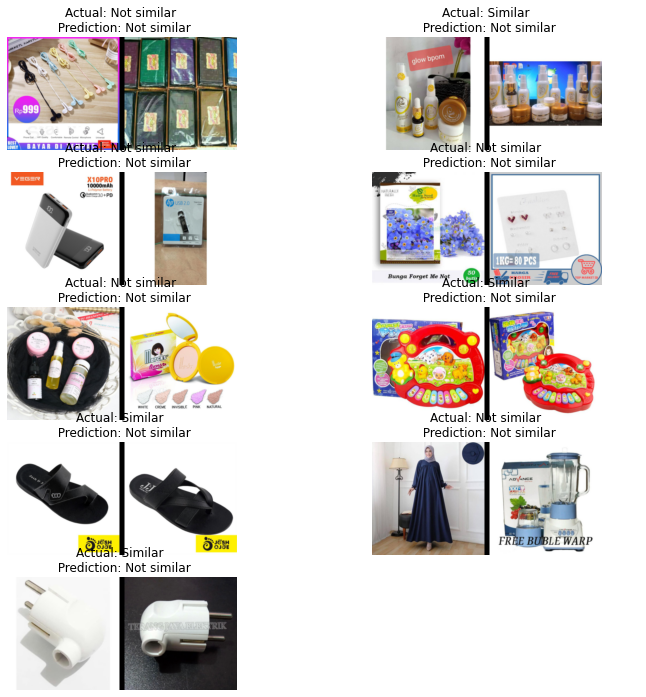

In [6]:
learn.show_results()